# Draft 1 - Figure 3

_Description of our goal:_  

Summary statistics for select regions over both obs. unc. products and all 4 GCMs

### Load functions and packages

In [2]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask, gridspec
    )

from functions import to_png

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from matplotlib.patches import Rectangle

def axis_breaky(axis, ypos=[0.1, 0.125], xpos=0,slant=1.5,w=0.1,zorder=3):
    d = slant  # proportion of vertical to horizontal extent of the slanted line
    anchor = (xpos,ypos[0])
    h = ypos[1] - ypos[0]

    kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12, zorder=zorder,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axis.add_patch(Rectangle(
        anchor, width=w, height=h, fill=True, color="white",
        transform=axis.transAxes, clip_on=False, zorder=zorder)
    )
    axis.plot([0, 0], ypos, transform=axis.transAxes, **kwargs)

### Load processed trend data

#### Models

In [3]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [4]:
cesm1_trends_filepath   = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_trends_filepath     = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_trends_filepath = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_trends_filepath   = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [5]:
cesm1_pic_trends_all   = xr.open_dataarray(*cesm1_trends_filepath)

mpi_pic_trends_all     = xr.open_dataarray(*mpi_trends_filepath)

canesm2_pic_trends_all = xr.open_dataarray(*canesm2_trends_filepath)

esm2m_pic_trends_all   = xr.open_dataarray(*esm2m_trends_filepath)

#### Observations

In [6]:
obs_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/'
hadcrut5_dir    = 'HadCRUT5/'

In [7]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'

In [8]:
gistemp_5x5_trends_filepath  = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_trends_filepath     = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,hadcrut5_dir))

Load the trend data

In [9]:
gistemp_5x5_trends_all  = xr.open_dataarray(*gistemp_5x5_trends_filepath)

hadcrut5_trends_all     = xr.open_dataarray(*hadcrut5_trends_filepath)

### Define functions

In [10]:
# These functions allow me to calculate a percentile across all variables for each month of the year. 
# Essentially a poorman's version of creating the numpy.percentile function within xarray. But it works!

def xr_percentile_wrapper(nparray,q,axis):
    '''
    Wrapper for a non-xarray function so that it returns a DataArray object.
    I am using nanpercentile here because it handles all cases.
    '''
    return xr.DataArray(np.nanpercentile(nparray,q=q,axis=axis))

def percentile_monthly_wrapper(data,dim,q,axis):
    
    return data.groupby(dim).map(xr_percentile_wrapper,q=q,axis=axis)

In [11]:
def percentile_vec(data,core_dim:str,q,**kwargs):
    
    data_chunk = data.chunk({core_dim:-1}) # needed!

    res_out = xr.apply_ufunc(np.nanpercentile,              # Function to apply
                             data_chunk,                      # Positional arguments for the function
                             input_core_dims=[[core_dim]],    # Dimension(s) to apply the function over
                             kwargs={**{'q':q}, **kwargs},                   # Keyword arguments for the function
                             # kwargs=kwargs,                   # Keyword arguments for the function
                             dask="parallelized",             # These may be necessary for efficient use via dask.
                             output_dtypes=['float64'],
                             vectorize = True)                # Vectorize
    
    return res_out


# You can also do this in numpy if you are ok converting back to xarray
# out_np = np.nanpercentile(data,q=95,axis=1,keepdims=False)

### Plot ideas!

Figure written description.

x-axis: IPCC region.

y-axis: TTE "true" and "mean" (slightly shifted from each other on the x-axis).

Symbols and colors will denote the different observational and model products.

## Compute time-to-emergence and observational delay

Calculate a 95% confidence interval on the PI-Control trends.

In [12]:
# CESM1
cesm1_pic_trends_2_5perc  = percentile_vec(cesm1_pic_trends_all,q=2.5,core_dim='startyear').compute()
cesm1_pic_trends_97_5perc = percentile_vec(cesm1_pic_trends_all,q=97.5,core_dim='startyear').compute()

# MPI-GE
mpi_pic_trends_2_5perc  = percentile_vec(mpi_pic_trends_all,q=2.5,core_dim='startyear').compute()
mpi_pic_trends_97_5perc = percentile_vec(mpi_pic_trends_all,q=97.5,core_dim='startyear').compute()

# CanESM2
canesm2_pic_trends_2_5perc  = percentile_vec(canesm2_pic_trends_all,q=2.5,core_dim='startyear').compute()
canesm2_pic_trends_97_5perc = percentile_vec(canesm2_pic_trends_all,q=97.5,core_dim='startyear').compute()

# ESM2M
esm2m_pic_trends_2_5perc  = percentile_vec(esm2m_pic_trends_all,q=2.5,core_dim='startyear').compute()
esm2m_pic_trends_97_5perc = percentile_vec(esm2m_pic_trends_all,q=97.5,core_dim='startyear').compute()

Observational Uncertainty

In [13]:
gistemp_5x5_trends_1960 = gistemp_5x5_trends_all.sel(startyear=1960)
hadcrut5_trends_1960    = hadcrut5_trends_all.sel(startyear=1960)

In [14]:
# Compute the low and high bounds on the trends from the observational products

# GISTEMP 5x5
gistemp_5x5_trends_2_5perc  = percentile_vec(gistemp_5x5_trends_1960,q=2.5,core_dim='record')
gistemp_5x5_trends_50perc  = percentile_vec(gistemp_5x5_trends_1960,q=50,core_dim='record')
gistemp_5x5_trends_97_5perc = percentile_vec(gistemp_5x5_trends_1960,q=97.5,core_dim='record')

# HadCRUT5 - have to cut off at 2020 so consistent with GISTEMP
hadcrut5_trends_2_5perc  = percentile_vec(hadcrut5_trends_1960,q=2.5,core_dim='realization').sel(duration=slice(None,60))
hadcrut5_trends_50perc  = percentile_vec(hadcrut5_trends_1960,q=50,core_dim='realization').sel(duration=slice(None,60))
hadcrut5_trends_97_5perc = percentile_vec(hadcrut5_trends_1960,q=97.5,core_dim='realization').sel(duration=slice(None,60))

### Compute TTE generally

I should be able to classify the delays in regions which haven't "truly" emerged using inequalities. i.e. obs-delay > 10 years

In [15]:
# Use nested dictionaries to order the data

model_trends_dict = {}

model_trends_dict['CESM1']   = {'2.5':cesm1_pic_trends_2_5perc,'97.5':cesm1_pic_trends_97_5perc}
model_trends_dict['MPI-GE']  = {'2.5':mpi_pic_trends_2_5perc,'97.5':mpi_pic_trends_97_5perc}
model_trends_dict['CanESM2'] = {'2.5':canesm2_pic_trends_2_5perc,'97.5':canesm2_pic_trends_97_5perc}
model_trends_dict['ESM2M']   = {'2.5':esm2m_pic_trends_2_5perc,'97.5':esm2m_pic_trends_97_5perc}

obs_trends_dict = {}

obs_trends_dict['GISTEMP_5x5'] = {'2.5':gistemp_5x5_trends_2_5perc,'50.0':gistemp_5x5_trends_50perc,'97.5':gistemp_5x5_trends_97_5perc}
obs_trends_dict['HadCRUT5_5x5'] = {'2.5':hadcrut5_trends_2_5perc,'50.0':hadcrut5_trends_50perc,'97.5':hadcrut5_trends_97_5perc}

In [16]:
def compute_tte(obs_trends,pic_trends):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    _tte_bool = obs_trends > pic_trends
    _tte      = 1960 + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=2020,np.nan) # Mask the unemerged regions
    
    return _tte
    
    # mean_tte_bool = gistemp_5x5_trends_50perc > cesm1_pic_trends_97_5perc
    # mean_tte      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')
    # mean_tte      = mean_tte.where(mean_tte!=2020,np.nan) # Mask the unemerged regions
    
    # return _tte

In [17]:
def compute_tte2(obs_trends_high,obs_trends_low,pic_trends_high,pic_trends_low):
    '''
    More general function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    # _tte_bool = obs_trends > pic_trends
    _tte_bool = np.bitwise_or(obs_trends_low > pic_trends_high,obs_trends_high < pic_trends_low)
    _tte      = 1960 + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=2020,np.nan) # Mask the unemerged regions
    
    return _tte
    
    # mean_tte_bool = gistemp_5x5_trends_50perc > cesm1_pic_trends_97_5perc
    # mean_tte      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')
    # mean_tte      = mean_tte.where(mean_tte!=2020,np.nan) # Mask the unemerged regions
    
    # return _tte

Iterate over the combinations of observational products and model products, computing the "true" and "mean" TTE.

In [18]:
final_tte_list = []

for _model in list(model_trends_dict.keys()):
    print(_model,end=': ')

    obs_product_list = []
    for _obs_prod in list(obs_trends_dict.keys()):
        print(_obs_prod,end=' ')
        
        _true_tte = compute_tte(obs_trends_dict[_obs_prod]['2.5'],model_trends_dict[_model]['97.5']).compute()
        _mean_tte = compute_tte(obs_trends_dict[_obs_prod]['50.0'],model_trends_dict[_model]['97.5']).compute()        
        
        _tte_pack = xr.concat([_mean_tte.assign_coords({'kind':'mean'}).expand_dims('kind',axis=-1),
                               _true_tte.assign_coords({'kind':'true'}).expand_dims('kind',axis=-1)],
                              dim='kind').assign_coords({'obs_prod':_obs_prod}).expand_dims('obs_prod',axis=-1)
        
        obs_product_list.append(_tte_pack)
    
    print('')
    final_tte_list.append(xr.concat(obs_product_list,dim='obs_prod').assign_coords({'model':_model}).expand_dims('model',axis=-1))
    
final_tte_ds = xr.concat(final_tte_list,dim='model')

CESM1: GISTEMP_5x5 HadCRUT5_5x5 
MPI-GE: GISTEMP_5x5 HadCRUT5_5x5 
CanESM2: GISTEMP_5x5 HadCRUT5_5x5 
ESM2M: GISTEMP_5x5 HadCRUT5_5x5 


### Figure 3

In [19]:
final_tte_ds.sel(RegionIndex=[3,4])

<xarray.DataArray 'duration' (RegionIndex: 2, kind: 2, obs_prod: 2, model: 4)>
array([[[[1999., 1999., 1998., 2003.],
         [1997., 1998., 1997., 2001.]],

        [[2000., 2001., 2000., 2005.],
         [1999., 2000., 1998., 2003.]]],


       [[[1999., 2005., 1998., 2001.],
         [1999., 2005., 1999., 2001.]],

        [[1999., 2006., 1999., 2002.],
         [2000., 2006., 1999., 2004.]]]])
Coordinates:
    RegionAbbrev  (RegionIndex) object 'WNA' 'CNA'
    RegionName    (RegionIndex) object 'W.North-America' 'C.North-America'
    startyear     int64 1960
  * obs_prod      (obs_prod) object 'GISTEMP_5x5' 'HadCRUT5_5x5'
  * kind          (kind) object 'mean' 'true'
  * RegionIndex   (RegionIndex) int64 3 4
  * model         (model) object 'CESM1' 'MPI-GE' 'CanESM2' 'ESM2M'

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


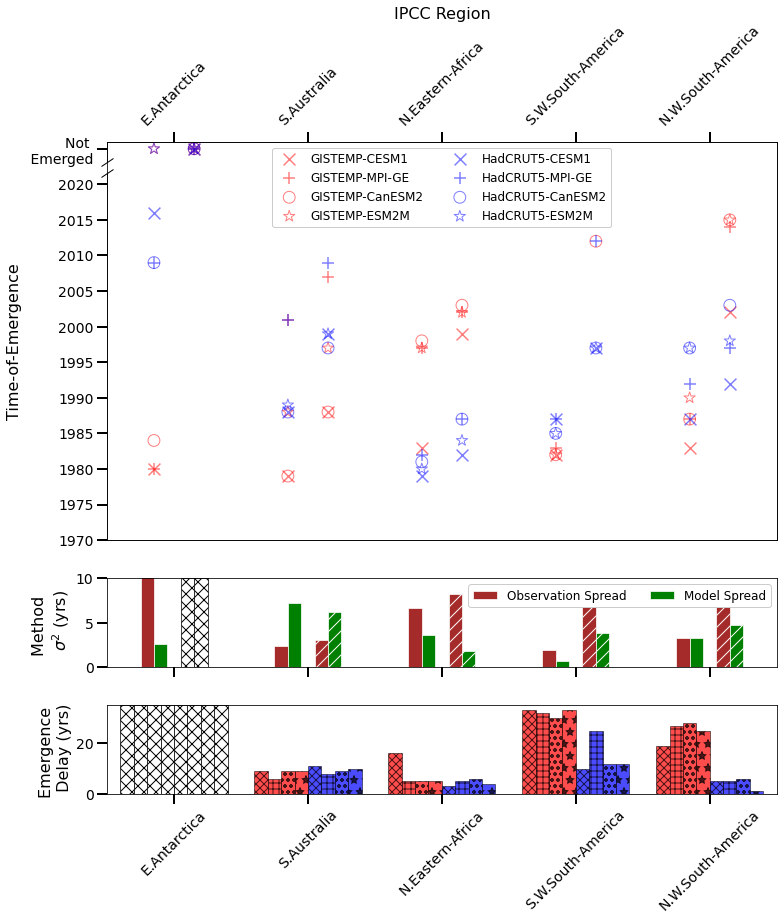

In [42]:
# symbols = ['x','s','o','v']
# symbols = ['x','s','o','*']
symbols = ['x','+','o','*']
hatches = ['xxx','++','oo','*']
colors  = ['red','blue']

# Symbols that need a fill color
fill_symbols = ['x','+']
s_value = 140

fig = plt.figure(figsize=(12,12))

gs = gridspec.GridSpec(3,1,height_ratios=[9,2,2],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1b = ax1.twiny()

# start_idx = 0
# stop_idx  = 18

region_indices = [44,42,23,13,9]

final_tte_subset = final_tte_ds.sel(RegionIndex=region_indices)

tick_labels = []


for i,(_index,_label) in enumerate(zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName)):
    # xstat = _index
    xstat = i
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _mean_subset = _region_subset.sel(kind='mean')
    _true_subset = _region_subset.sel(kind='true')

    _mean_obs_unc = _mean_subset.std(dim='obs_prod').mean(dim='model')
    _mean_mod_unc = _mean_subset.std(dim='model').mean(dim='obs_prod')
    
    _true_obs_unc = _true_subset.std(dim='obs_prod').mean(dim='model')
    _true_mod_unc = _true_subset.std(dim='model').mean(dim='obs_prod')
    
    _mean_obs_spread = (_mean_subset.max(dim='obs_prod') - _mean_subset.min(dim='obs_prod')).mean(dim='model')
    _mean_mod_spread = (_mean_subset.max(dim='model') - _mean_subset.min(dim='model')).mean(dim='obs_prod')
    
    _true_obs_spread = (_true_subset.max(dim='obs_prod') - _true_subset.min(dim='obs_prod')).mean()
    _true_mod_spread = (_true_subset.max(dim='model') - _true_subset.min(dim='model')).mean(dim='obs_prod')
    
    _delay_avg = (_true_subset - _mean_subset).mean(dim=['obs_prod','model'])
    _delay = _true_subset - _mean_subset
    
    ax2.bar(xstat-0.2, _mean_obs_unc, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
    ax2.bar(xstat-0.1, _mean_mod_unc, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
    ax2.bar(xstat+0.1, _true_obs_unc, width=0.1, color='brown', edgecolor="white", linewidth=0.7, hatch='//')
    ax2.bar(xstat+0.2, _true_mod_unc, width=0.1, color='green', edgecolor="white", linewidth=0.7, hatch='//')
    
    # Look to hide nans
    if np.isnan(_mean_obs_unc):
        ax2.bar(xstat-0.2, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_mean_mod_unc):
        ax2.bar(xstat-0.1, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_obs_unc):
        ax2.bar(xstat+0.1, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_mod_unc):
        ax2.bar(xstat+0.2, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')        
    
    _offset = -0.35   
    
    for _obs,_color in zip(_mean_subset.obs_prod,colors):

        _obs_subset = _mean_subset.sel(obs_prod=_obs)

        for _model,_symbol,_hatch in zip(_obs_subset.model,symbols,hatches):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
            if (_symbol in fill_symbols):
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                
            if (np.isnan(_delay.sel(obs_prod=_obs,model=_model))):
                ax3.bar(xstat+_offset, 35, 
                        width=0.1, color='white',edgecolor="black",
                        hatch='xx',linewidth=0.7)
            else:
                ax3.bar(xstat+_offset,_delay.sel(obs_prod=_obs,model=_model),
                        width=0.1,color=_color,alpha=0.7,edgecolor="black",
                        hatch=_hatch,linewidth=0.7)
            
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                    
            _offset += 0.1

    for _obs,_color in zip(_true_subset.obs_prod,colors):

        _obs_subset = _true_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            if (_symbol in fill_symbols):
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
        
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)                

# Prep legend with fake plots.
for _obs,_color in zip(_true_subset.obs_prod,colors):

    _obs_subset = _true_subset.sel(obs_prod=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        obs_str   = str(_obs.values)[:-4]
        model_str = str(_model.values)
        if (_symbol in fill_symbols):
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors=_color,edgecolors=_color)
        else:
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors='none',edgecolors=_color)
        
ax2.bar(0,0, width=0.1, color='brown', edgecolor="white", linewidth=0.7, label='Observation Spread')
ax2.bar(0,0, width=0.1, color='green', edgecolor="white", linewidth=0.7, label='Model Spread')
# ax2.bar(0,0, width=0.5, color='gray',  edgecolor="black", linewidth=0.7, alpha=0.3, label='Average Delay')
        
# ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
ax1.vlines(final_tte_subset.RegionIndex,ymin=1970,ymax=2026,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)
ax2.vlines(final_tte_subset.RegionIndex,ymin=0,ymax=20,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)

# Lower panel settings
# ax1.set_xlabel('IPCC Region',fontsize=16)
ax1.set_ylabel('Time-of-Emergence',fontsize=16)
ax1.set_xticks(np.arange(1,5+1))
ax1.set_xticklabels(['' for i in range(5)],fontsize=14,rotation=45)
ax1.set_yticks(np.arange(1970,2026,5))
ax1.set_yticklabels([str(1970+5*i) for i in range(len(ax1.get_yticks())-1)]+['Not \n Emerged'])
ax1.set_xlim(-0.5,4.5)
ax1.set_ylim(1970,2026)
ax1.tick_params(axis='x',labelsize=14,length=0,width=0)
ax1.tick_params(axis='y',labelsize=14,length=10,width=2)

ax1b.set_xticks(np.arange(0,5))
ax1b.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax1b.set_xlim(-0.5,4.5)
ax1b.tick_params(axis='both',labelsize=14,length=10,width=2)
ax1b.set_xlabel('IPCC Region',fontsize=16)

# Upper panel settings
ax2.set_ylabel('Method \n $\sigma^2$ (yrs)',fontsize=16)
ax2.set_xticks(np.arange(0,5))
ax2.set_xticklabels(['' for i in range(5)],fontsize=14,rotation=45)
ax2.set_xlim(-0.5,4.5)
ax2.set_ylim(0,10)
ax2.tick_params(axis='both',labelsize=14,length=10,width=2)

# Delay panel settings
ax3.set_ylabel('Emergence \n Delay (yrs)',fontsize=16)
ax3.set_xticks(np.arange(0,5))
# ax3.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax3.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax3.set_xlim(-0.5,4.5)
ax3.set_ylim(0,35)
ax3.tick_params(axis='both',labelsize=14,length=10,width=2)

# Axis breaks. I think it can't draw over the plot border because of gridspec
axis_breaky(ax1, ypos=[0.92,0.95], slant=1.5,xpos=0.0,zorder=50,w=0.01)

ax1.legend(ncol=2,loc='best',fontsize=12,facecolor='white', framealpha=1)
ax2.legend(ncol=2,loc='best',fontsize=12,facecolor='white', framealpha=1)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


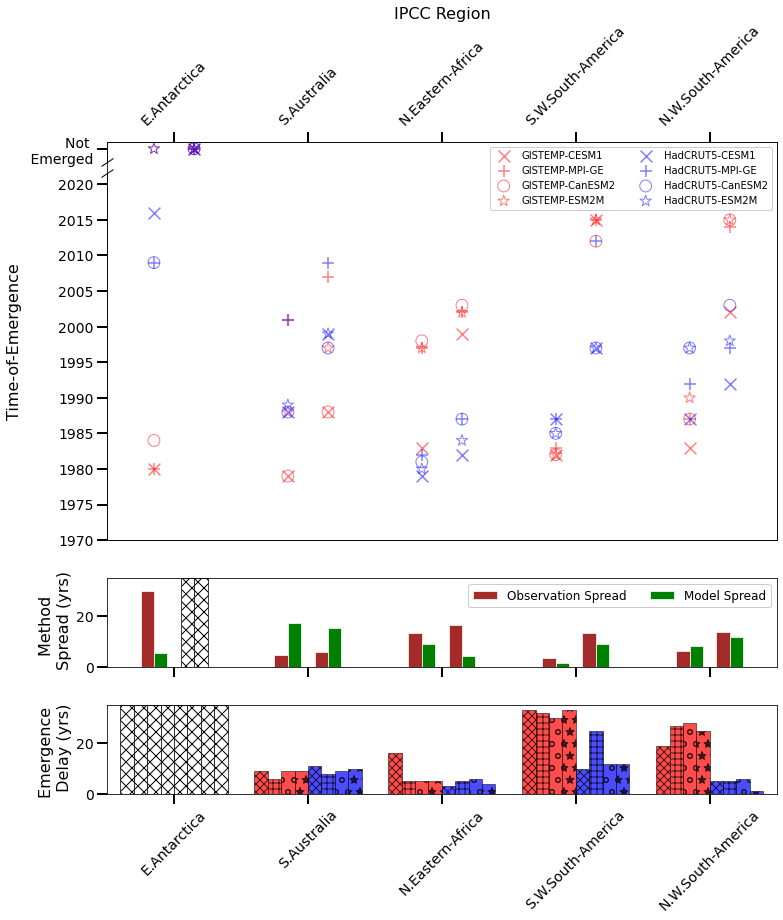

In [58]:
symbols = ['x','+','o','*']
hatches = ['xxx','++','o','*']
colors  = ['red','blue']

# Symbols that need a fill color
fill_symbols = ['x','+']
s_value = 140

fig = plt.figure(figsize=(12,12))

gs = gridspec.GridSpec(3,1,height_ratios=[9,2,2],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1b = ax1.twiny()

# start_idx = 0
# stop_idx  = 18

region_indices = [44,42,23,13,9]

final_tte_subset = final_tte_ds.sel(RegionIndex=region_indices)

tick_labels = []


for i,(_index,_label) in enumerate(zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName)):
    # xstat = _index
    xstat = i
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _mean_subset = _region_subset.sel(kind='mean')
    _true_subset = _region_subset.sel(kind='true')
    
    _mean_obs_spread = (_mean_subset.max(dim='obs_prod') - _mean_subset.min(dim='obs_prod')).mean(dim='model')
    _mean_mod_spread = (_mean_subset.max(dim='model') - _mean_subset.min(dim='model')).mean(dim='obs_prod')
    
    _true_obs_spread = (_true_subset.max(dim='obs_prod') - _true_subset.min(dim='obs_prod')).mean()
    _true_mod_spread = (_true_subset.max(dim='model') - _true_subset.min(dim='model')).mean(dim='obs_prod')
    
    _delay_avg = (_true_subset - _mean_subset).mean(dim=['obs_prod','model'])
    _delay = _true_subset - _mean_subset
    
    ax2.bar(xstat-0.2, _mean_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
    ax2.bar(xstat-0.1, _mean_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
    ax2.bar(xstat+0.1, _true_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)#, hatch='//')
    ax2.bar(xstat+0.2, _true_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)#, hatch='//')
    
    # Look to hide nans
    if np.isnan(_mean_obs_spread):
        ax2.bar(xstat-0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_mean_mod_spread):
        ax2.bar(xstat-0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_obs_spread):
        ax2.bar(xstat+0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_mod_spread):
        ax2.bar(xstat+0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')     
    
    _offset = -0.35   
    
    for _obs,_color in zip(_mean_subset.obs_prod,colors):

        _obs_subset = _mean_subset.sel(obs_prod=_obs)

        for _model,_symbol,_hatch in zip(_obs_subset.model,symbols,hatches):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
            if (_symbol in fill_symbols):
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                
            if (np.isnan(_delay.sel(obs_prod=_obs,model=_model))):
                ax3.bar(xstat+_offset, 35, 
                        width=0.1, color='white',edgecolor="black",
                        hatch='xx',linewidth=0.7)
            else:
                ax3.bar(xstat+_offset,_delay.sel(obs_prod=_obs,model=_model),
                        width=0.1,color=_color,alpha=0.7,edgecolor="black",
                        hatch=_hatch,linewidth=0.7)
            
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                    
            _offset += 0.1

    for _obs,_color in zip(_true_subset.obs_prod,colors):

        _obs_subset = _true_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            if (_symbol in fill_symbols):
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
        
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)                

# Prep legend with fake plots.
for _obs,_color in zip(_true_subset.obs_prod,colors):

    _obs_subset = _true_subset.sel(obs_prod=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        obs_str   = str(_obs.values)[:-4]
        model_str = str(_model.values)
        if (_symbol in fill_symbols):
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors=_color,edgecolors=_color)
        else:
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors='none',edgecolors=_color)
        
ax2.bar(0,0, width=0.1, color='brown', edgecolor="white", linewidth=0.7, label='Observation Spread')
ax2.bar(0,0, width=0.1, color='green', edgecolor="white", linewidth=0.7, label='Model Spread')
# ax2.bar(0,0, width=0.5, color='gray',  edgecolor="black", linewidth=0.7, alpha=0.3, label='Average Delay')
        
# ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
ax1.vlines(final_tte_subset.RegionIndex,ymin=1970,ymax=2026,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)
ax2.vlines(final_tte_subset.RegionIndex,ymin=0,ymax=20,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)

# Lower panel settings
# ax1.set_xlabel('IPCC Region',fontsize=16)
ax1.set_ylabel('Time-of-Emergence',fontsize=16)
ax1.set_xticks(np.arange(1,5+1))
ax1.set_xticklabels(['' for i in range(5)],fontsize=14,rotation=45)
ax1.set_yticks(np.arange(1970,2026,5))
ax1.set_yticklabels([str(1970+5*i) for i in range(len(ax1.get_yticks())-1)]+['Not \n Emerged'])
ax1.set_xlim(-0.5,4.5)
ax1.set_ylim(1970,2026)
ax1.tick_params(axis='x',labelsize=14,length=0,width=0)
ax1.tick_params(axis='y',labelsize=14,length=10,width=2)

ax1b.set_xticks(np.arange(0,5))
ax1b.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax1b.set_xlim(-0.5,4.5)
ax1b.tick_params(axis='both',labelsize=14,length=10,width=2)
ax1b.set_xlabel('IPCC Region',fontsize=16)

# Upper panel settings
ax2.set_ylabel('Method \n Spread (yrs)',fontsize=16)
ax2.set_xticks(np.arange(0,5))
ax2.set_xticklabels(['' for i in range(5)],fontsize=14,rotation=45)
ax2.set_xlim(-0.5,4.5)
ax2.set_ylim(0,35)
ax2.tick_params(axis='both',labelsize=14,length=10,width=2)

# Delay panel settings
ax3.set_ylabel('Emergence \n Delay (yrs)',fontsize=16)
ax3.set_xticks(np.arange(0,5))
# ax3.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax3.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax3.set_xlim(-0.5,4.5)
ax3.set_ylim(0,35)
ax3.tick_params(axis='both',labelsize=14,length=10,width=2)

# Axis breaks. I think it can't draw over the plot border because of gridspec
axis_breaky(ax1, ypos=[0.92,0.95], slant=1.5,xpos=0.0,zorder=50,w=0.01)

ax1.legend(ncol=2,loc='best',fontsize=10,facecolor='white', framealpha=1)
ax2.legend(ncol=2,loc='best',fontsize=12,facecolor='white', framealpha=1)

In [56]:
to_png(file=fig,filename='TOE_comparison_IPCCregions_coneplots',dpi=300,ext='png',bbox_inches='tight')

### Supplemental Figures

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


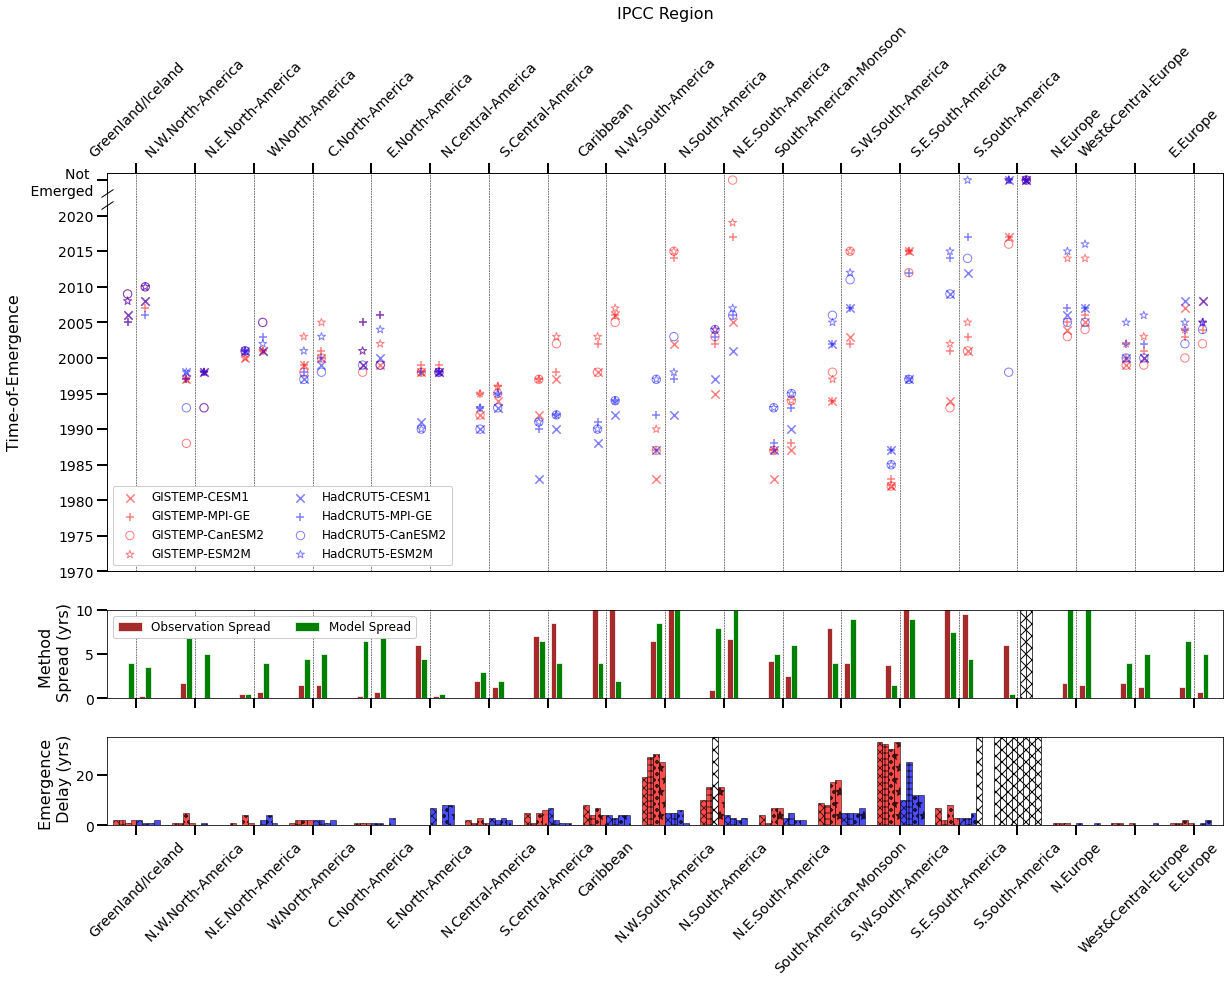

In [60]:
# symbols = ['x','s','o','v']
# symbols = ['x','s','o','*']
symbols = ['x','+','o','*']
hatches = ['xxx','++','oo','*']
colors  = ['red','blue']

# Symbols that need a fill color
fill_symbols = ['x','+']
s_value = 70

fig = plt.figure(figsize=(20,12))

gs = gridspec.GridSpec(3,1,height_ratios=[9,2,2],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1b = ax1.twiny()

start_idx = 0
stop_idx  = 18

final_tte_subset = final_tte_ds.sel(RegionIndex=slice(start_idx,stop_idx))

tick_labels = []


for _index,_label in zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName):
    xstat = _index
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _mean_subset = _region_subset.sel(kind='mean')
    _true_subset = _region_subset.sel(kind='true')

    _mean_obs_spread = (_mean_subset.max(dim='obs_prod') - _mean_subset.min(dim='obs_prod')).mean(dim='model')
    _mean_mod_spread = (_mean_subset.max(dim='model') - _mean_subset.min(dim='model')).mean(dim='obs_prod')
    
    _true_obs_spread = (_true_subset.max(dim='obs_prod') - _true_subset.min(dim='obs_prod')).mean()
    _true_mod_spread = (_true_subset.max(dim='model') - _true_subset.min(dim='model')).mean(dim='obs_prod')
    
    _delay_avg = (_true_subset - _mean_subset).mean(dim=['obs_prod','model'])
    _delay = _true_subset - _mean_subset
    
    ax2.bar(xstat-0.2, _mean_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
    ax2.bar(xstat-0.1, _mean_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
    ax2.bar(xstat+0.1, _true_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)#, hatch='//')
    ax2.bar(xstat+0.2, _true_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)#, hatch='//')
    
    # Look to hide nans
    if np.isnan(_mean_obs_spread):
        ax2.bar(xstat-0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_mean_mod_spread):
        ax2.bar(xstat-0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_obs_spread):
        ax2.bar(xstat+0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_mod_spread):
        ax2.bar(xstat+0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')     
    
#     _mean_obs_unc = _mean_subset.std(dim='obs_prod').mean(dim='model')
#     _mean_mod_unc = _mean_subset.std(dim='model').mean(dim='obs_prod')
    
#     _true_obs_unc = _true_subset.std(dim='obs_prod').mean(dim='model')
#     _true_mod_unc = _true_subset.std(dim='model').mean(dim='obs_prod')
    
#     _delay_avg = (_true_subset - _mean_subset).mean(dim=['obs_prod','model'])
#     _delay = _true_subset - _mean_subset
    
#     ax2.bar(xstat-0.2, _mean_obs_unc, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
#     ax2.bar(xstat-0.1, _mean_mod_unc, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
#     ax2.bar(xstat+0.1, _true_obs_unc, width=0.1, color='brown', edgecolor="white", linewidth=0.7, hatch='//')
#     ax2.bar(xstat+0.2, _true_mod_unc, width=0.1, color='green', edgecolor="white", linewidth=0.7, hatch='//')
    
#     # Look to hide nans
#     if np.isnan(_mean_obs_unc):
#         ax2.bar(xstat-0.2, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
#     if np.isnan(_mean_mod_unc):
#         ax2.bar(xstat-0.1, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
#     if np.isnan(_true_obs_unc):
#         ax2.bar(xstat+0.1, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
#     if np.isnan(_true_mod_unc):
#         ax2.bar(xstat+0.2, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')        
    
    _offset = -0.35   
    
    for _obs,_color in zip(_mean_subset.obs_prod,colors):

        _obs_subset = _mean_subset.sel(obs_prod=_obs)

        for _model,_symbol,_hatch in zip(_obs_subset.model,symbols,hatches):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
            if (_symbol in fill_symbols):
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                
            if (np.isnan(_delay.sel(obs_prod=_obs,model=_model))):
                ax3.bar(xstat+_offset, 35, 
                        width=0.1, color='white',edgecolor="black",
                        hatch='xx',linewidth=0.7)
            else:
                ax3.bar(xstat+_offset,_delay.sel(obs_prod=_obs,model=_model),
                        width=0.1,color=_color,alpha=0.7,edgecolor="black",
                        hatch=_hatch,linewidth=0.7)
            
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                    
            _offset += 0.1

    for _obs,_color in zip(_true_subset.obs_prod,colors):

        _obs_subset = _true_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            if (_symbol in fill_symbols):
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
        
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)                

# Prep legend with fake plots.
for _obs,_color in zip(_true_subset.obs_prod,colors):

    _obs_subset = _true_subset.sel(obs_prod=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        obs_str   = str(_obs.values)[:-4]
        model_str = str(_model.values)
        if (_symbol in fill_symbols):
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors=_color,edgecolors=_color)
        else:
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors='none',edgecolors=_color)
        
ax2.bar(0,0, width=0.1, color='brown', edgecolor="white", linewidth=0.7, label='Observation Spread')
ax2.bar(0,0, width=0.1, color='green', edgecolor="white", linewidth=0.7, label='Model Spread')
# ax2.bar(0,0, width=0.5, color='gray',  edgecolor="black", linewidth=0.7, alpha=0.3, label='Average Delay')
        
# ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
ax1.vlines(final_tte_subset.RegionIndex,ymin=1970,ymax=2026,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)
ax2.vlines(final_tte_subset.RegionIndex,ymin=0,ymax=20,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)

# Lower panel settings
# ax1.set_xlabel('IPCC Region',fontsize=16)
ax1.set_ylabel('Time-of-Emergence',fontsize=16)
ax1.set_xticks(np.arange(start_idx,stop_idx+1))
ax1.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax1.set_yticks(np.arange(1970,2026,5))
ax1.set_yticklabels([str(1970+5*i) for i in range(len(ax1.get_yticks())-1)]+['Not \n Emerged'])
ax1.set_xlim(start_idx-0.5,stop_idx+0.5)
ax1.set_ylim(1970,2026)
ax1.tick_params(axis='x',labelsize=14,length=0,width=0)
ax1.tick_params(axis='y',labelsize=14,length=10,width=2)

ax1b.set_xticks(np.arange(start_idx,stop_idx+1))
ax1b.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax1b.set_xlim(start_idx-0.5,stop_idx+0.5)
ax1b.tick_params(axis='both',labelsize=14,length=10,width=2)
ax1b.set_xlabel('IPCC Region',fontsize=16)

# Upper panel settings
ax2.set_ylabel('Method \n Spread (yrs)',fontsize=16)
ax2.set_xticks(np.arange(start_idx,stop_idx+1))
ax2.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax2.set_xlim(start_idx-0.5,stop_idx+0.5)
ax2.set_ylim(0,10)
ax2.tick_params(axis='both',labelsize=14,length=10,width=2)

# Delay panel settings
ax3.set_ylabel('Emergence \n Delay (yrs)',fontsize=16)
ax3.set_xticks(np.arange(start_idx,stop_idx+1))
# ax3.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax3.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax3.set_xlim(start_idx-0.5,stop_idx+0.5)
ax3.set_ylim(0,35)
ax3.tick_params(axis='both',labelsize=14,length=10,width=2)

# Axis breaks. I think it can't draw over the plot border because of gridspec
axis_breaky(ax1, ypos=[0.92,0.95], slant=1.5,xpos=0.0,zorder=50,w=0.01)

ax1.legend(ncol=2,loc='best',fontsize=12,facecolor='white', framealpha=1)
ax2.legend(ncol=2,loc='best',fontsize=12,facecolor='white', framealpha=1)

In [89]:
to_png(file=fig,filename='TOE_comparison_IPCCregions_0_18',dpi=300,ext='pdf',bbox_inches='tight')

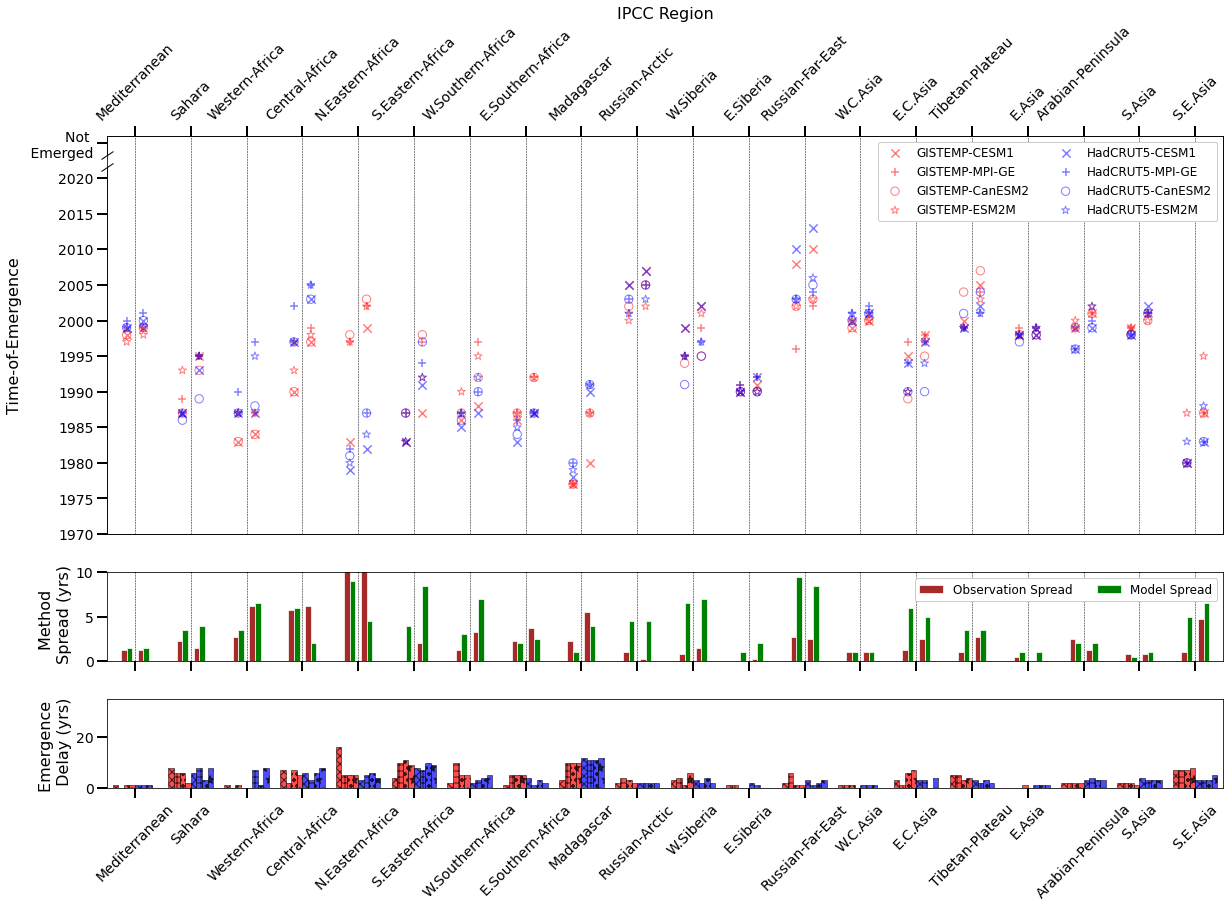

In [61]:
# symbols = ['x','s','o','v']
# symbols = ['x','s','o','*']
symbols = ['x','+','o','*']
hatches = ['xxx','++','oo','*']
colors  = ['red','blue']

# Symbols that need a fill color
fill_symbols = ['x','+']
s_value = 70

fig = plt.figure(figsize=(20,12))

gs = gridspec.GridSpec(3,1,height_ratios=[9,2,2],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1b = ax1.twiny()

start_idx = 19
stop_idx  = 38

final_tte_subset = final_tte_ds.sel(RegionIndex=slice(start_idx,stop_idx))

tick_labels = []


for _index,_label in zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName):
    xstat = _index
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _mean_subset = _region_subset.sel(kind='mean')
    _true_subset = _region_subset.sel(kind='true')

    _mean_obs_spread = (_mean_subset.max(dim='obs_prod') - _mean_subset.min(dim='obs_prod')).mean(dim='model')
    _mean_mod_spread = (_mean_subset.max(dim='model') - _mean_subset.min(dim='model')).mean(dim='obs_prod')
    
    _true_obs_spread = (_true_subset.max(dim='obs_prod') - _true_subset.min(dim='obs_prod')).mean()
    _true_mod_spread = (_true_subset.max(dim='model') - _true_subset.min(dim='model')).mean(dim='obs_prod')
    
    _delay_avg = (_true_subset - _mean_subset).mean(dim=['obs_prod','model'])
    _delay = _true_subset - _mean_subset
    
    ax2.bar(xstat-0.2, _mean_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
    ax2.bar(xstat-0.1, _mean_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
    ax2.bar(xstat+0.1, _true_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)#, hatch='//')
    ax2.bar(xstat+0.2, _true_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)#, hatch='//')
    
    # Look to hide nans
    if np.isnan(_mean_obs_spread):
        ax2.bar(xstat-0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_mean_mod_spread):
        ax2.bar(xstat-0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_obs_spread):
        ax2.bar(xstat+0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_mod_spread):
        ax2.bar(xstat+0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx') 
    
#     _mean_obs_unc = _mean_subset.std(dim='obs_prod').mean(dim='model')
#     _mean_mod_unc = _mean_subset.std(dim='model').mean(dim='obs_prod')
    
#     _true_obs_unc = _true_subset.std(dim='obs_prod').mean(dim='model')
#     _true_mod_unc = _true_subset.std(dim='model').mean(dim='obs_prod')
    
#     _delay_avg = (_true_subset - _mean_subset).mean(dim=['obs_prod','model'])
#     _delay = _true_subset - _mean_subset
    
#     ax2.bar(xstat-0.2, _mean_obs_unc, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
#     ax2.bar(xstat-0.1, _mean_mod_unc, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
#     ax2.bar(xstat+0.1, _true_obs_unc, width=0.1, color='brown', edgecolor="white", linewidth=0.7, hatch='//')
#     ax2.bar(xstat+0.2, _true_mod_unc, width=0.1, color='green', edgecolor="white", linewidth=0.7, hatch='//')
    
#     # Look to hide nans
#     if np.isnan(_mean_obs_unc):
#         ax2.bar(xstat-0.2, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
#     if np.isnan(_mean_mod_unc):
#         ax2.bar(xstat-0.1, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
#     if np.isnan(_true_obs_unc):
#         ax2.bar(xstat+0.1, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
#     if np.isnan(_true_mod_unc):
#         ax2.bar(xstat+0.2, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')        
    
    _offset = -0.35   
    
    for _obs,_color in zip(_mean_subset.obs_prod,colors):

        _obs_subset = _mean_subset.sel(obs_prod=_obs)

        for _model,_symbol,_hatch in zip(_obs_subset.model,symbols,hatches):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
            if (_symbol in fill_symbols):
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                
            if (np.isnan(_delay.sel(obs_prod=_obs,model=_model))):
                ax3.bar(xstat+_offset, 35, 
                        width=0.1, color='white',edgecolor="black",
                        hatch='xx',linewidth=0.7)
            else:
                ax3.bar(xstat+_offset,_delay.sel(obs_prod=_obs,model=_model),
                        width=0.1,color=_color,alpha=0.7,edgecolor="black",
                        hatch=_hatch,linewidth=0.7)
            
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                    
            _offset += 0.1

    for _obs,_color in zip(_true_subset.obs_prod,colors):

        _obs_subset = _true_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            if (_symbol in fill_symbols):
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
        
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)                

# Prep legend with fake plots.
for _obs,_color in zip(_true_subset.obs_prod,colors):

    _obs_subset = _true_subset.sel(obs_prod=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        obs_str   = str(_obs.values)[:-4]
        model_str = str(_model.values)
        if (_symbol in fill_symbols):
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors=_color,edgecolors=_color)
        else:
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors='none',edgecolors=_color)
        
ax2.bar(0,0, width=0.1, color='brown', edgecolor="white", linewidth=0.7, label='Observation Spread')
ax2.bar(0,0, width=0.1, color='green', edgecolor="white", linewidth=0.7, label='Model Spread')
# ax2.bar(0,0, width=0.5, color='gray',  edgecolor="black", linewidth=0.7, alpha=0.3, label='Average Delay')
        
# ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
ax1.vlines(final_tte_subset.RegionIndex,ymin=1970,ymax=2026,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)
ax2.vlines(final_tte_subset.RegionIndex,ymin=0,ymax=20,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)

# Lower panel settings
# ax1.set_xlabel('IPCC Region',fontsize=16)
ax1.set_ylabel('Time-of-Emergence',fontsize=16)
ax1.set_xticks(np.arange(start_idx,stop_idx+1))
ax1.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax1.set_yticks(np.arange(1970,2026,5))
ax1.set_yticklabels([str(1970+5*i) for i in range(len(ax1.get_yticks())-1)]+['Not \n Emerged'])
ax1.set_xlim(start_idx-0.5,stop_idx+0.5)
ax1.set_ylim(1970,2026)
ax1.tick_params(axis='x',labelsize=14,length=0,width=0)
ax1.tick_params(axis='y',labelsize=14,length=10,width=2)

ax1b.set_xticks(np.arange(start_idx,stop_idx+1))
ax1b.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax1b.set_xlim(start_idx-0.5,stop_idx+0.5)
ax1b.tick_params(axis='both',labelsize=14,length=10,width=2)
ax1b.set_xlabel('IPCC Region',fontsize=16)

# Upper panel settings
ax2.set_ylabel('Method \n Spread (yrs)',fontsize=16)
ax2.set_xticks(np.arange(start_idx,stop_idx+1))
ax2.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax2.set_xlim(start_idx-0.5,stop_idx+0.5)
ax2.set_ylim(0,10)
ax2.tick_params(axis='both',labelsize=14,length=10,width=2)

# Delay panel settings
ax3.set_ylabel('Emergence \n Delay (yrs)',fontsize=16)
ax3.set_xticks(np.arange(start_idx,stop_idx+1))
# ax3.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax3.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax3.set_xlim(start_idx-0.5,stop_idx+0.5)
ax3.set_ylim(0,35)
ax3.tick_params(axis='both',labelsize=14,length=10,width=2)

# Axis breaks. I think it can't draw over the plot border because of gridspec
axis_breaky(ax1, ypos=[0.92,0.95], slant=1.5,xpos=0.0,zorder=50,w=0.01)

ax1.legend(ncol=2,loc='best',fontsize=12,facecolor='white', framealpha=1)
ax2.legend(ncol=2,loc='best',fontsize=12,facecolor='white', framealpha=1)

In [91]:
to_png(file=fig,filename='TOE_comparison_IPCCregions_19_38',dpi=300,ext='pdf',bbox_inches='tight')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/

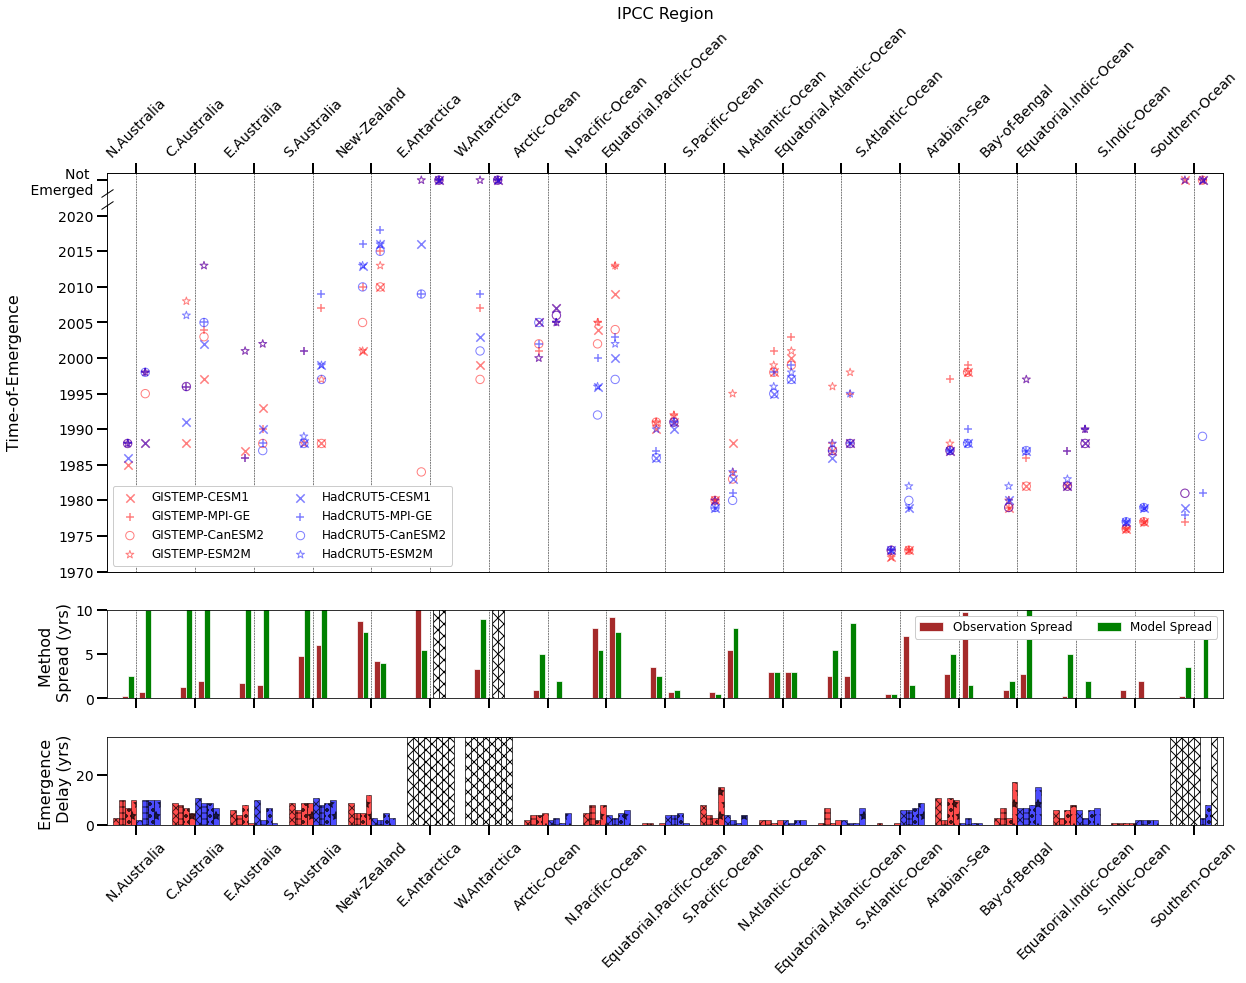

In [62]:
# symbols = ['x','s','o','v']
# symbols = ['x','s','o','*']
symbols = ['x','+','o','*']
hatches = ['xxx','++','oo','*']
colors  = ['red','blue']

# Symbols that need a fill color
fill_symbols = ['x','+']
s_value = 70

fig = plt.figure(figsize=(20,12))

gs = gridspec.GridSpec(3,1,height_ratios=[9,2,2],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1b = ax1.twiny()

start_idx = 39
stop_idx  = 57

final_tte_subset = final_tte_ds.sel(RegionIndex=slice(start_idx,stop_idx))

tick_labels = []


for _index,_label in zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName):
    xstat = _index
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _mean_subset = _region_subset.sel(kind='mean')
    _true_subset = _region_subset.sel(kind='true')

    _mean_obs_spread = (_mean_subset.max(dim='obs_prod') - _mean_subset.min(dim='obs_prod')).mean(dim='model')
    _mean_mod_spread = (_mean_subset.max(dim='model') - _mean_subset.min(dim='model')).mean(dim='obs_prod')
    
    _true_obs_spread = (_true_subset.max(dim='obs_prod') - _true_subset.min(dim='obs_prod')).mean()
    _true_mod_spread = (_true_subset.max(dim='model') - _true_subset.min(dim='model')).mean(dim='obs_prod')
    
    _delay_avg = (_true_subset - _mean_subset).mean(dim=['obs_prod','model'])
    _delay = _true_subset - _mean_subset
    
    ax2.bar(xstat-0.2, _mean_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
    ax2.bar(xstat-0.1, _mean_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
    ax2.bar(xstat+0.1, _true_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)#, hatch='//')
    ax2.bar(xstat+0.2, _true_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)#, hatch='//')
    
    # Look to hide nans
    if np.isnan(_mean_obs_spread):
        ax2.bar(xstat-0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_mean_mod_spread):
        ax2.bar(xstat-0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_obs_spread):
        ax2.bar(xstat+0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
    if np.isnan(_true_mod_spread):
        ax2.bar(xstat+0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')     
    
#     _mean_obs_unc = _mean_subset.std(dim='obs_prod').mean(dim='model')
#     _mean_mod_unc = _mean_subset.std(dim='model').mean(dim='obs_prod')
    
#     _true_obs_unc = _true_subset.std(dim='obs_prod').mean(dim='model')
#     _true_mod_unc = _true_subset.std(dim='model').mean(dim='obs_prod')
    
#     _delay_avg = (_true_subset - _mean_subset).mean(dim=['obs_prod','model'])
#     _delay = _true_subset - _mean_subset
    
#     ax2.bar(xstat-0.2, _mean_obs_unc, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
#     ax2.bar(xstat-0.1, _mean_mod_unc, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
#     ax2.bar(xstat+0.1, _true_obs_unc, width=0.1, color='brown', edgecolor="white", linewidth=0.7, hatch='//')
#     ax2.bar(xstat+0.2, _true_mod_unc, width=0.1, color='green', edgecolor="white", linewidth=0.7, hatch='//')
    
#     # Look to hide nans
#     if np.isnan(_mean_obs_unc):
#         ax2.bar(xstat-0.2, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
#     if np.isnan(_mean_mod_unc):
#         ax2.bar(xstat-0.1, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
#     if np.isnan(_true_obs_unc):
#         ax2.bar(xstat+0.1, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')
#     if np.isnan(_true_mod_unc):
#         ax2.bar(xstat+0.2, 10, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch='xx')        
    
    _offset = -0.35   
    
    for _obs,_color in zip(_mean_subset.obs_prod,colors):

        _obs_subset = _mean_subset.sel(obs_prod=_obs)

        for _model,_symbol,_hatch in zip(_obs_subset.model,symbols,hatches):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
            if (_symbol in fill_symbols):
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                
            if (np.isnan(_delay.sel(obs_prod=_obs,model=_model))):
                ax3.bar(xstat+_offset, 35, 
                        width=0.1, color='white',edgecolor="black",
                        hatch='xx',linewidth=0.7)
            else:
                ax3.bar(xstat+_offset,_delay.sel(obs_prod=_obs,model=_model),
                        width=0.1,color=_color,alpha=0.7,edgecolor="black",
                        hatch=_hatch,linewidth=0.7)
            
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                    
            _offset += 0.1

    for _obs,_color in zip(_true_subset.obs_prod,colors):

        _obs_subset = _true_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            if (_symbol in fill_symbols):
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
        
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)                

# Prep legend with fake plots.
for _obs,_color in zip(_true_subset.obs_prod,colors):

    _obs_subset = _true_subset.sel(obs_prod=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        obs_str   = str(_obs.values)[:-4]
        model_str = str(_model.values)
        if (_symbol in fill_symbols):
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors=_color,edgecolors=_color)
        else:
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors='none',edgecolors=_color)
        
ax2.bar(0,0, width=0.1, color='brown', edgecolor="white", linewidth=0.7, label='Observation Spread')
ax2.bar(0,0, width=0.1, color='green', edgecolor="white", linewidth=0.7, label='Model Spread')
# ax2.bar(0,0, width=0.5, color='gray',  edgecolor="black", linewidth=0.7, alpha=0.3, label='Average Delay')
        
# ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
ax1.vlines(final_tte_subset.RegionIndex,ymin=1970,ymax=2026,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)
ax2.vlines(final_tte_subset.RegionIndex,ymin=0,ymax=20,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)

# Lower panel settings
# ax1.set_xlabel('IPCC Region',fontsize=16)
ax1.set_ylabel('Time-of-Emergence',fontsize=16)
ax1.set_xticks(np.arange(start_idx,stop_idx+1))
ax1.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax1.set_yticks(np.arange(1970,2026,5))
ax1.set_yticklabels([str(1970+5*i) for i in range(len(ax1.get_yticks())-1)]+['Not \n Emerged'])
ax1.set_xlim(start_idx-0.5,stop_idx+0.5)
ax1.set_ylim(1970,2026)
ax1.tick_params(axis='x',labelsize=14,length=0,width=0)
ax1.tick_params(axis='y',labelsize=14,length=10,width=2)

ax1b.set_xticks(np.arange(start_idx,stop_idx+1))
ax1b.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax1b.set_xlim(start_idx-0.5,stop_idx+0.5)
ax1b.tick_params(axis='both',labelsize=14,length=10,width=2)
ax1b.set_xlabel('IPCC Region',fontsize=16)

# Upper panel settings
ax2.set_ylabel('Method \n Spread (yrs)',fontsize=16)
ax2.set_xticks(np.arange(start_idx,stop_idx+1))
ax2.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax2.set_xlim(start_idx-0.5,stop_idx+0.5)
ax2.set_ylim(0,10)
ax2.tick_params(axis='both',labelsize=14,length=10,width=2)

# Delay panel settings
ax3.set_ylabel('Emergence \n Delay (yrs)',fontsize=16)
ax3.set_xticks(np.arange(start_idx,stop_idx+1))
# ax3.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax3.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax3.set_xlim(start_idx-0.5,stop_idx+0.5)
ax3.set_ylim(0,35)
ax3.tick_params(axis='both',labelsize=14,length=10,width=2)

# Axis breaks. I think it can't draw over the plot border because of gridspec
axis_breaky(ax1, ypos=[0.92,0.95], slant=1.5,xpos=0.0,zorder=50,w=0.01)

ax1.legend(ncol=2,loc='best',fontsize=12,facecolor='white', framealpha=1)
ax2.legend(ncol=2,loc='best',fontsize=12,facecolor='white', framealpha=1)

In [93]:
to_png(file=fig,filename='TOE_comparison_IPCCregions_39_57',dpi=300,ext='pdf',bbox_inches='tight')